# Lista de exercísios #2

**Dataset treinamento:** `Kstarmumu_Combined_10K.csv` (binary `label`: 1 = signal, 0 = background)  
**Dataset dados reais:** `Kstarmumu_Data_2016_RM.csv`

**Context:** Binary classification for $ B \to K^{*}\mu^+\mu^- $ (signal vs. background)  
**Libraries:** NumPy, pandas, scikit-learn, matplotlib

# Preparacao das variaveis vistas anteoriormente

In [1]:
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

CSV_PATH = "/shared_dataset/Met_Stat_HEP_AI_School/Kstarmumu_Combined_10K.csv"
assert os.path.exists(CSV_PATH), f"CSV not found at {CSV_PATH}"
df = pd.read_csv(CSV_PATH)

# escolha 2 features
X1 = "B0_ENDVERTEX_CHI2"
X2 = "B0_IPCHI2_OWNPV"
x = df[X1].values
y = df[X2].values
t = df['label'].astype(int).values

# (a) Definir limiares nas medianas

In [2]:
tx       = np.median(x)
ty_left  = np.median(y[x <  tx])
ty_right = np.median(y[x >= tx])

print(f"tx={tx:.3g}, ty_left={ty_left:.3g}, ty_right={ty_right:.3g}")

tx=7.98, ty_left=1.68, ty_right=3.75


# (b) Criar regras

In [3]:
def predict_tree_2layers(x, y, tx, ty_left, ty_right, low_y_is_signal=True):
    """
    Árvore de 2 camadas:
         [ x < tx ? ]
          /      \
      ESQ         DIR
     (y vs ty_L) (y vs ty_R)
    """
    n = len(x)
    pred = np.zeros(n, dtype=int)

    for i in range(n):  # percorre cada evento
        if x[i] < tx:   # lado esquerdo
            if low_y_is_signal:
                pred[i] = 1 if y[i] < ty_left else 0
            else:
                pred[i] = 1 if y[i] >= ty_left else 0
        else:           # lado direito
            if low_y_is_signal:
                pred[i] = 1 if y[i] < ty_right else 0
            else:
                pred[i] = 1 if y[i] >= ty_right else 0
    return pred
pred_median = predict_tree_2layers(x, y, tx, ty_left, ty_right, low_y_is_signal=True)

# (c) Plotar as regioes

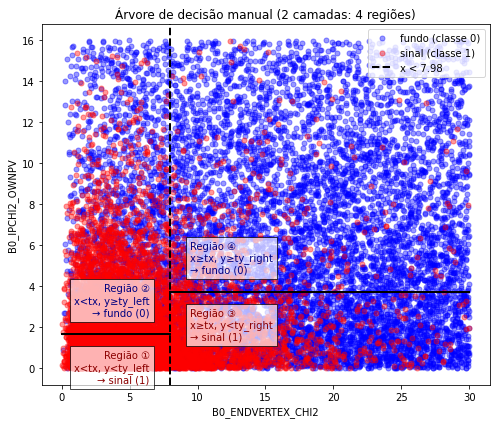

In [4]:
def plot_decision_tree2(x, y, t, tx, ty_left, ty_right):
    plt.figure(figsize=(7,6))

    # Pontos reais
    plt.scatter(x[t==0], y[t==0], c='blue', s=25, label='fundo (classe 0)', alpha=0.4)
    plt.scatter(x[t==1], y[t==1], c='red',  s=25, label='sinal (classe 1)', alpha=0.4)

    # Fronteiras
    plt.axvline(tx, color='k', lw=2, ls='--', label=f"x < {tx:.2f}")
    plt.plot([np.min(x), tx], [ty_left, ty_left],  color='k', lw=2)
    plt.plot([tx, np.max(x)], [ty_right, ty_right], color='k', lw=2)

    # Texto explicativo: 4 regiões
    dx = 0.05 * (np.max(x) - np.min(x))
    dy = 0.05 * (np.max(y) - np.min(y))

    plt.text(tx - dx, ty_left - dy, 
             "Região ①\nx<tx, y<ty_left\n→ sinal (1)", 
             ha='right', va='top', color='darkred',
             bbox=dict(facecolor='white', alpha=0.7))

    plt.text(tx - dx, ty_left + dy, 
             "Região ②\nx<tx, y≥ty_left\n→ fundo (0)", 
             ha='right', va='bottom', color='navy',
             bbox=dict(facecolor='white', alpha=0.7))

    plt.text(tx + dx, ty_right - dy, 
             "Região ③\nx≥tx, y<ty_right\n→ sinal (1)", 
             ha='left', va='top', color='darkred',
             bbox=dict(facecolor='white', alpha=0.7))

    plt.text(tx + dx, ty_right + dy, 
             "Região ④\nx≥tx, y≥ty_right\n→ fundo (0)", 
             ha='left', va='bottom', color='navy',
             bbox=dict(facecolor='white', alpha=0.7))

    # Labels e título
    plt.xlabel(X1)
    plt.ylabel(X2)
    plt.legend(loc='upper right')
    plt.title("Árvore de decisão manual (2 camadas: 4 regiões)")
    plt.tight_layout()
    plt.show()

    
plot_decision_tree2(x, y, t, tx, ty_left, ty_right)

# (d) Ajustar manualmente os cortes

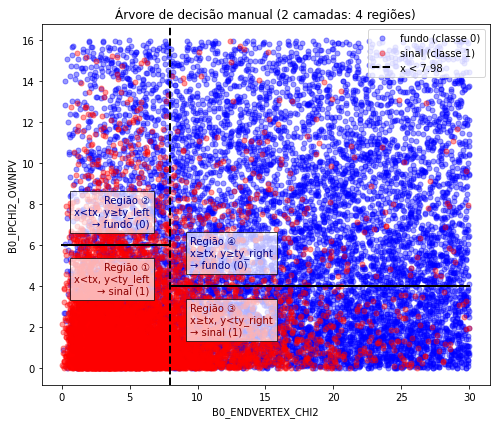

In [5]:
tx_man  = np.median(x)
tyL_man = 6.0
tyR_man = 4.0
pred_manual = predict_tree_2layers(x, y, tx_man, tyL_man, tyR_man, low_y_is_signal=True)

plot_decision_tree2(x, y, t, tx_man, tyL_man, tyR_man)

# (e) Calcular a eficiência de sinal e rejeição de background

In [6]:
def compute_eff_rej_simple(y_true, y_pred):
    """
    Calcula:
      - Eficiência de sinal: fração de eventos sinal corretamente classificados.
      - Rejeição de fundo: fração de eventos fundo corretamente rejeitados.
    Tudo feito 'na mão', sem usar confusion_matrix.
    """
    # índices de cada classe
    sig_idx = (y_true == 1)
    bkg_idx = (y_true == 0)

    # sinal verdadeiro → predito como 1
    tp = np.sum(y_pred[sig_idx] == 1)
    fn = np.sum(y_pred[sig_idx] == 0)

    # fundo verdadeiro → predito como 0
    tn = np.sum(y_pred[bkg_idx] == 0)
    fp = np.sum(y_pred[bkg_idx] == 1)

    eff_signal = tp / (tp + fn) if (tp + fn) > 0 else 0   # TPR
    rej_bkg     = tn / (tn + fp) if (tn + fp) > 0 else 0   # TNR

    return eff_signal, rej_bkg

# calcula para os dois métodos
eff_median, rej_median = compute_eff_rej_simple(t, pred_median)
eff_manual, rej_manual = compute_eff_rej_simple(t, pred_manual)

# mostra os resultados
print(f"--- Cortes por Mediana ---")
print(f"Eficiência de sinal (TPR): {eff_median:.3f}")
print(f"Rejeição de fundo (TNR):  {rej_median:.3f}\n")

print(f"--- Cortes Manuais ---")
print(f"Eficiência de sinal (TPR): {eff_manual:.3f}")
print(f"Rejeição de fundo (TNR):  {rej_manual:.3f}")

--- Cortes por Mediana ---
Eficiência de sinal (TPR): 0.630
Rejeição de fundo (TNR):  0.630

--- Cortes Manuais ---
Eficiência de sinal (TPR): 0.915
Rejeição de fundo (TNR):  0.529


# Extra: Decision tree

In [7]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# 1. preparamos os dados
XY = np.c_[x, y]       # usa as duas variáveis escolhidas
y_true = t             # rótulos verdadeiros (0=fundo, 1=sinal)

# 2. criamos e treinamos a árvore
dt = DecisionTreeClassifier(max_depth=2, random_state=42)
dt.fit(XY, y_true)

# 3. aplicamos a árvore para prever
y_pred = dt.predict(XY)

# 4. calculamos eficiência de sinal e rejeição de fundo
sig_idx = (y_true == 1)
bkg_idx = (y_true == 0)

eff_signal = np.sum(y_pred[sig_idx] == 1) / np.sum(sig_idx)
rej_bkg    = np.sum(y_pred[bkg_idx] == 0) / np.sum(bkg_idx)

# 5. mostramos os resultados
print(f"Eficiência de sinal (TPR): {eff_signal:.3f}")
print(f"Rejeição de fundo (TNR):  {rej_bkg:.3f}")

Eficiência de sinal (TPR): 0.782
Rejeição de fundo (TNR):  0.848


# Exercisio 2

In [8]:
# ====== imports básicos ======
import os, numpy as np, pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import (roc_curve, roc_auc_score, confusion_matrix, classification_report,
                             accuracy_score, ConfusionMatrixDisplay)
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import learning_curve, StratifiedKFold

from sklearn.metrics import roc_curve, roc_auc_score

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ====== caminho do seu CSV ======
CSV_PATH = "/shared_dataset/Met_Stat_HEP_AI_School/Kstarmumu_Combined_10K.csv"
assert os.path.exists(CSV_PATH), f"CSV não encontrado em {CSV_PATH}"

df = pd.read_csv(CSV_PATH)
assert 'label' in df.columns, "CSV precisa conter a coluna 'label' (0=fundo, 1=sinal)."

print(df.shape, "linhas x colunas")
df.head()


(20001, 18) linhas x colunas


,B0_M,B0_P,B0_PT,B0_DIRA_OWNPV,B0_ENDVERTEX_CHI2,B0_TAU,K_PIDK,Pi_PIDK,mu_plus_PIDmu,mu_minus_PIDmu,B0_FDCHI2_OWNPV,B0_IPCHI2_OWNPV,K_IPCHI2_OWNPV,Pi_IPCHI2_OWNPV,mu_plus_IPCHI2_OWNPV,mu_minus_IPCHI2_OWNPV,q2,label
0,5293.991001,75896.203841,8909.803377,0.999999,4.905650,0.001284,90.508797,-46.337502,12.187781,7.432416,3081.747660,0.371431,59.050087,83.338387,1780.312976,28.701731,9.663302,1
1,5288.832014,126115.585086,10691.039729,1.000000,2.004244,0.001243,24.425800,-30.905701,2.919568,6.710679,2156.295071,0.518954,117.929828,16.125493,148.942208,193.719177,9.641775,1
2,5295.424405,114864.557485,2406.324645,0.999998,12.073755,0.002071,28.216801,-18.581900,6.832418,9.504477,2660.020136,2.568881,27.325995,15.858291,1612.783038,468.393934,9.759748,1
3,5269.043465,54960.554640,2282.680501,0.999985,1.617552,0.001040,27.841700,-56.836899,4.109861,8.587584,607.622240,1.330499,80.198100,98.543575,290.049372,65.434165,9.535254,1
4,5283.438848,152677.844241,7923.259410,1.000000,4.073691,0.004821,6.273400,-31.115299,6.782620,10.778706,30945.021839,5.415031,641.926005,318.035248,1603.637163,10081.557016,9.629298,1


# Separar features (X) e alvo (y)

In [9]:
# usamos todas as colunas exceto 'label' e 'B0_M'
num_cols = [c for c in df.columns if c not in ['label', 'B0_M','q2']]
X = df[num_cols].values
y = df['label'].astype(int).values

# informações básicas do dataset
print("n_features:", X.shape[1])
print("features usadas:", num_cols)

n_features: 15
features usadas: ['B0_P', 'B0_PT', 'B0_DIRA_OWNPV', 'B0_ENDVERTEX_CHI2', 'B0_TAU', 'K_PIDK', 'Pi_PIDK', 'mu_plus_PIDmu', 'mu_minus_PIDmu', 'B0_FDCHI2_OWNPV', 'B0_IPCHI2_OWNPV', 'K_IPCHI2_OWNPV', 'Pi_IPCHI2_OWNPV', 'mu_plus_IPCHI2_OWNPV', 'mu_minus_IPCHI2_OWNPV']


# Funções auxiliares

In [10]:
def plot_corr_heatmap(df_num, title="Correlação (Pearson)"):
    C = np.corrcoef(df_num.T)
    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.imshow(C, vmin=-1, vmax=1)
    ax.set_title(title)
    ax.set_xticks(range(len(df_num.columns))); ax.set_xticklabels(df_num.columns, rotation=90, fontsize=8)
    ax.set_yticks(range(len(df_num.columns))); ax.set_yticklabels(df_num.columns, fontsize=8)
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout(); plt.show()

def plot_learning_curve(estimator, X, y,
                               cv_splits=5,
                               scoring='accuracy',
                               train_sizes=np.linspace(0.3, 1.0, 5),
                               random_state=42):
    """
    Gera uma curva de aprendizado simples com estratificação e métrica de acurácia.
    """
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=random_state)

    sizes, train_scores, val_scores = learning_curve(
        estimator, X, y,
        cv=cv,
        train_sizes=train_sizes,
        scoring=scoring,
        n_jobs=-1,
        shuffle=True,
        random_state=random_state
    )

    train_mean = train_scores.mean(axis=1)
    train_std = train_scores.std(axis=1)
    val_mean = val_scores.mean(axis=1)
    val_std = val_scores.std(axis=1)

    plt.figure()
    plt.plot(sizes, train_mean, label="Treino", marker='o')
    plt.fill_between(sizes, train_mean - train_std, train_mean + train_std, alpha=0.2)
    plt.plot(sizes, val_mean, label="Validação", marker='s')
    plt.fill_between(sizes, val_mean - val_std, val_mean + val_std, alpha=0.2)
    plt.xlabel("Tamanho do conjunto de treino")
    plt.ylabel(scoring.capitalize())
    plt.title("Curva de aprendizado")
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.show()

def plot_performance(clf, X_train, y_train, X_test, y_test, bins=40, invert=False, title="TMVA-like"):
    """
    Plot do score do classificador para S/B em treino e teste.
    """
    # Scores = probabilidade de ser sinal (classe 1)
    s_tr = clf.predict_proba(X_train)[:, 1]
    s_te = clf.predict_proba(X_test)[:, 1]
    if invert:
        s_tr = 1.0 - s_tr
        s_te = 1.0 - s_te

    # separa por classe
    s_tr_sig = s_tr[y_train == 1]; s_tr_bkg = s_tr[y_train == 0]
    s_te_sig = s_te[y_test  == 1]; s_te_bkg = s_te[y_test  == 0]

    # bins comuns (0..1)
    edges = np.linspace(0, 1, bins + 1)

    plt.figure(figsize=(7,4.5))
    # Treino preenchido
    plt.hist(s_tr_sig, bins=edges, alpha=0.35, label="S (train)", color="tab:red")
    plt.hist(s_tr_bkg, bins=edges, alpha=0.35, label="B (train)", color="tab:blue")
    # Teste como linha (ou pontos)
    plt.hist(s_te_sig, bins=edges, histtype="step", linewidth=1.8, label="S (test)", color="tab:red")
    plt.hist(s_te_bkg, bins=edges, histtype="step", linewidth=1.8, label="B (test)", color="tab:blue")

    plt.xlabel("Classifier output (score de sinal)")
    plt.ylabel("Counts / bin")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()


def plot_roc_with_auc(model, X_test, y_test, name="Modelo"):
    """
    Plota a curva ROC e escreve o valor do AUC dentro do gráfico.
    Supõe que o modelo já foi treinado.
    """
    # obtém a pontuação do classificador (probabilidade da classe 1)
    y_score = model.predict_proba(X_test)[:, 1]

    # calcula FPR, TPR e AUC
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc = roc_auc_score(y_test, y_score)

    # plota
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"{name}")
    plt.plot([0, 1], [0, 1], "--", color="gray", linewidth=1)
    plt.xlabel("Taxa de falsos positivos (FPR)")
    plt.ylabel("Taxa de verdadeiros positivos (TPR)")
    plt.title("Curva ROC")

    # adiciona o valor do AUC dentro do gráfico
    plt.text(0.65, 0.15, f"AUC = {auc:.3f}",
             transform=plt.gca().transAxes,
             fontsize=10,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

    plt.legend()
    plt.tight_layout()
    plt.show()
    return auc



# 1) Decision Tree (modelo base)

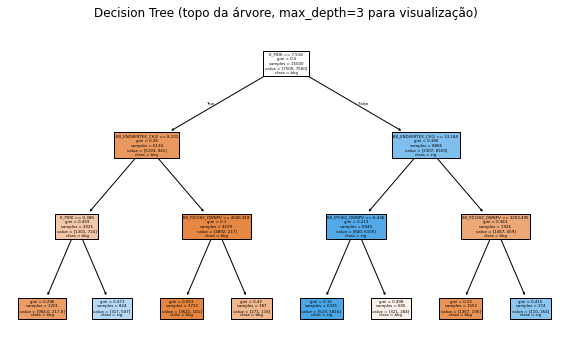

In [27]:
# split estável
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y)

# árvore simples com hiperparâmetros default
#dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=50,random_state=RANDOM_STATE)
dt.fit(X_train, y_train)

# Apenas para mostrar 1 vez
plt.figure(figsize=(10,6))
plot_tree(dt, max_depth=3, filled=True, feature_names=num_cols, class_names=["bkg","sig"])
plt.title("Decision Tree (topo da árvore, max_depth=3 para visualização)")
plt.show()


# 2 - Métricas e gráficos de análise

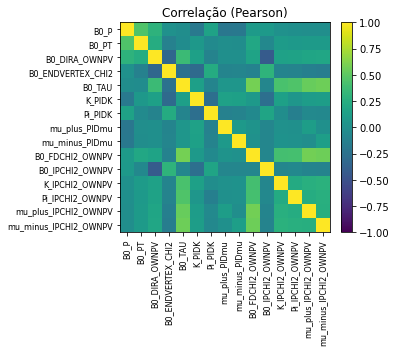

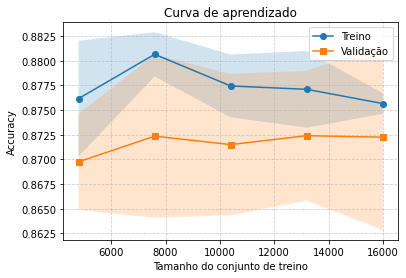

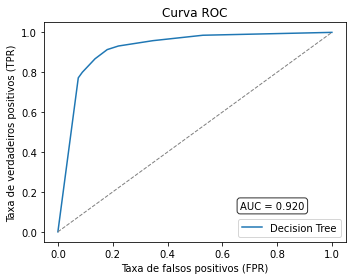

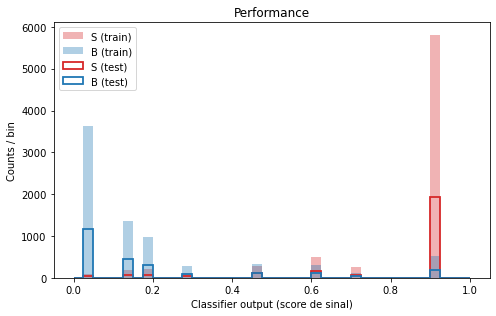

In [28]:
# (a) Correlação entre variáveis
plot_corr_heatmap(df[num_cols])

# (b) Learning curve (usamos AUC como métrica)
plot_learning_curve(dt, X, y)

# (c) Plot ROC curve
plot_roc_with_auc(dt, X_test, y_test, name="Decision Tree")

# (d) plot treino/validacao
plot_performance(dt, X_train, y_train, X_test, y_test, bins=40, invert=False, title="Performance")

# 3 - Ajuste simples de hiperparâmetros

Fitting 5 folds for each of 45 candidates, totalling 225 fits

Resumo dos modelos testados (ordenado por AUC médio):
 mean_test_score  std_test_score param_max_depth  param_min_samples_split  param_min_samples_leaf
           0.962           0.002               8                       50                      20
           0.962           0.002               8                       10                      20
           0.962           0.002               8                        2                      20
           0.961           0.001            None                       50                      20
           0.961           0.002               8                       50                       5
           0.960           0.001              12                       50                      20
           0.960           0.001            None                        2                      20
           0.960           0.001            None                       10                      20
 

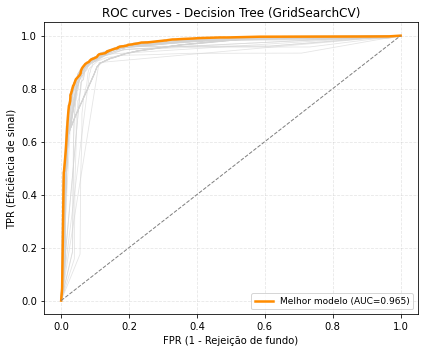

In [13]:
param_grid = {
    "max_depth": [None, 4, 6, 8, 12],
    "min_samples_split": [2, 10, 50],
    "min_samples_leaf": [1, 5, 20],
}
grid_dt = GridSearchCV(
    DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid,
    scoring="roc_auc",
    cv=5, n_jobs=-1, verbose=1
)
grid_dt.fit(X_train, y_train)

# converte os resultados do grid em DataFrame
df_results = pd.DataFrame(grid_dt.cv_results_)

# cria lista das colunas certas com prefixo 'param_'
cols = ['mean_test_score', 'std_test_score'] + [
    f'param_{k}' for k in param_grid.keys()
]

# seleciona e ordena por desempenho (AUC)
df_results = df_results[cols].sort_values(by='mean_test_score', ascending=False)

# imprime tabela resumida
print("\nResumo dos modelos testados (ordenado por AUC médio):")
print(df_results.round(3).to_string(index=False))

plt.figure(figsize=(6, 5))

# percorre todas as combinações testadas
for params in grid_dt.cv_results_['params']:
    # treina novamente um modelo com cada combinação
    model = DecisionTreeClassifier(**params, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, color='lightgray', lw=0.8, alpha=0.6)

# curva da melhor configuração em destaque
best_model = grid_dt.best_estimator_
y_best = best_model.predict_proba(X_test)[:, 1]
fpr_best, tpr_best, _ = roc_curve(y_test, y_best)
auc_best = roc_auc_score(y_test, y_best)

plt.plot(fpr_best, tpr_best, color='darkorange', lw=2.5,
         label=f"Melhor modelo (AUC={auc_best:.3f})")

# linha diagonal
plt.plot([0, 1], [0, 1], '--', color='gray', lw=1)

# estilo do plot
plt.xlabel("FPR (1 - Rejeição de fundo)")
plt.ylabel("TPR (Eficiência de sinal)")
plt.title("ROC curves - Decision Tree (GridSearchCV)")
plt.legend(loc="lower right", fontsize=9)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# 4) Seleção/eliminação de features (feature importance)

In [14]:
# importância das features do best_dt
importances = pd.Series(dt.feature_importances_, index=num_cols).sort_values(ascending=False)
importances.head(15)

K_PIDK                   0.576553
B0_ENDVERTEX_CHI2        0.320672
B0_FDCHI2_OWNPV          0.054908
B0_IPCHI2_OWNPV          0.047867
B0_P                     0.000000
B0_PT                    0.000000
B0_DIRA_OWNPV            0.000000
B0_TAU                   0.000000
Pi_PIDK                  0.000000
mu_plus_PIDmu            0.000000
mu_minus_PIDmu           0.000000
K_IPCHI2_OWNPV           0.000000
Pi_IPCHI2_OWNPV          0.000000
mu_plus_IPCHI2_OWNPV     0.000000
mu_minus_IPCHI2_OWNPV    0.000000
dtype: float64


=== Avaliando top-5 features ===


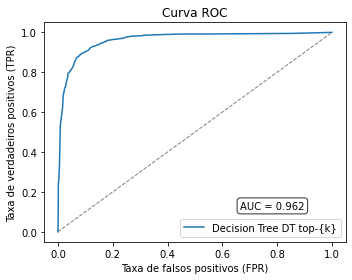


=== Avaliando top-10 features ===


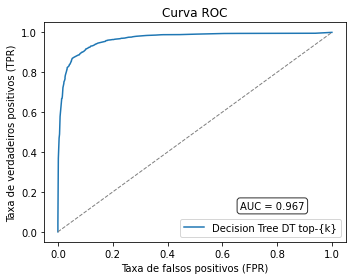


=== Avaliando top-15 features ===


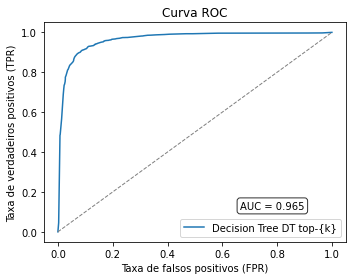


=== Avaliando top-15 features ===


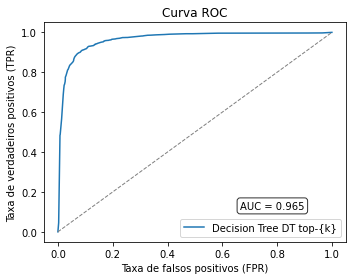

In [15]:
# testando top-k
def evaluate_topk(k):
    topk_cols = importances.index[:k].tolist()
    Xk_train = df[topk_cols].values
    Xk_test  = df[topk_cols].values
    # para manter a comparabilidade, reusa o mesmo split:
    Xk_train, Xk_test, yk_train, yk_test = train_test_split(
        Xk_train, y, test_size=0.25, random_state=RANDOM_STATE, stratify=y
    )
    clf = DecisionTreeClassifier(random_state=RANDOM_STATE, **grid_dt.best_params_)
    clf.fit(Xk_train, yk_train)
    plot_roc_with_auc(clf, Xk_test, yk_test, name="Decision Tree DT top-{k}")
    #return eval_classif(clf, Xk_train, Xk_test, yk_train, yk_test, name=f"DT top-{k}")

for k in [5, 10, 15, X.shape[1]]:
    print(f"\n=== Avaliando top-{k} features ===")
    _ = evaluate_topk(k)


# 5) Cross-validation (k-fold)

In [16]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
base_dt = DecisionTreeClassifier(random_state=RANDOM_STATE, **grid_dt.best_params_)

auc_scores = cross_val_score(base_dt, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
acc_scores = cross_val_score(base_dt, X, y, cv=cv, scoring="accuracy", n_jobs=-1)

print("CV (5-fold) AUC  -> média=", auc_scores.mean().round(3), "±", auc_scores.std().round(3))
print("CV (5-fold) ACC  -> média=", acc_scores.mean().round(3), "±", acc_scores.std().round(3))

CV (5-fold) AUC  -> média= 0.962 ± 0.003
CV (5-fold) ACC  -> média= 0.907 ± 0.006


# 6) Random forest

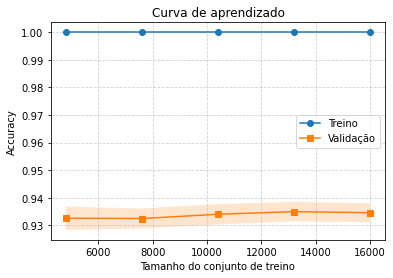

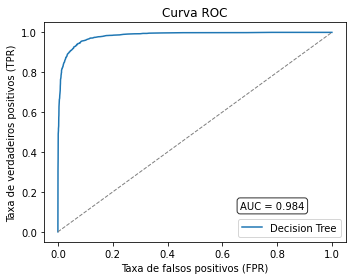

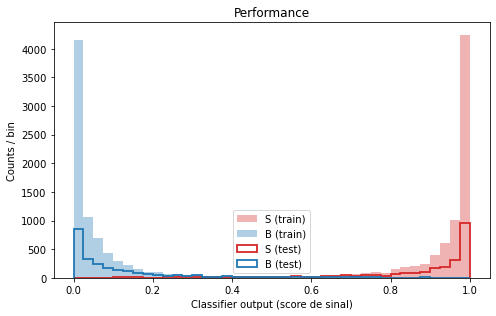

In [17]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    n_jobs=-1,
    random_state=RANDOM_STATE
)
rf.fit(X_train, y_train)

# (b) Learning curve (usamos AUC como métrica)
plot_learning_curve(rf, X, y)

# (c) Plot ROC curve
plot_roc_with_auc(rf, X_test, y_test, name="Decision Tree")

# (d) plot treino/validacao
plot_performance(rf, X_train, y_train, X_test, y_test, bins=40, invert=False, title="Performance")

# 7) Gradient Boosting

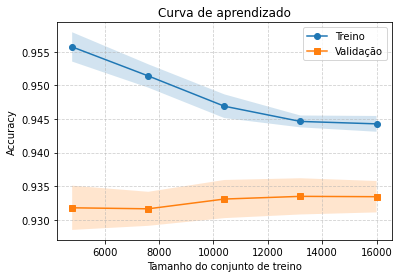

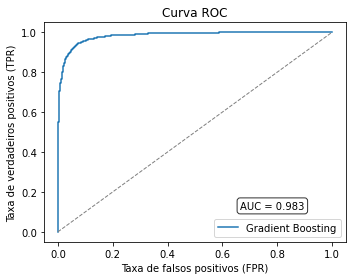

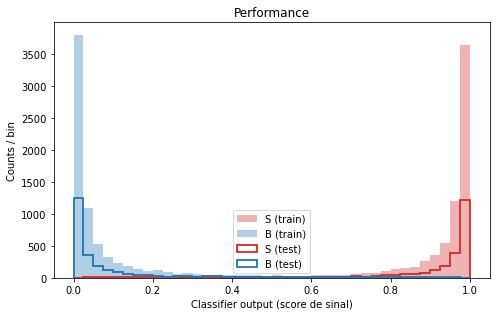

In [18]:
gb = GradientBoostingClassifier(random_state=RANDOM_STATE)
gb.fit(X_train, y_train)

# (b) Learning curve (usamos AUC como métrica)
plot_learning_curve(gb, X, y)

# (c) Plot ROC curve
plot_roc_with_auc(gb, X_test, y_test, name="Gradient Boosting")

# (d) plot treino/validacao
plot_performance(gb, X_train, y_train, X_test, y_test, bins=40, invert=False, title="Performance")

# Variando os hiperparâmetros do Gradient Boosting

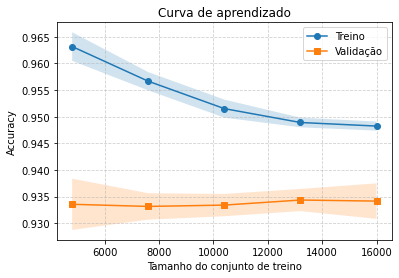

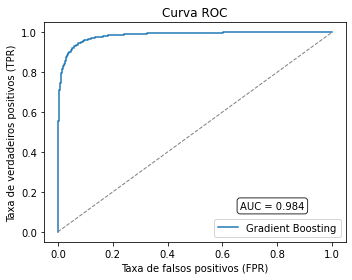

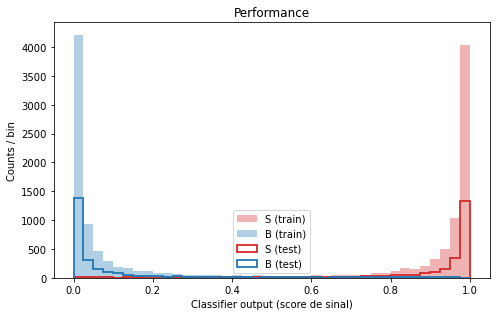

In [19]:
gb2 = GradientBoostingClassifier(
    n_estimators=300,      # mais etapas
    max_depth=3,          # profundidade das árvores base
    learning_rate=0.05,
    random_state=RANDOM_STATE
)

gb2.fit(X_train, y_train)

# (b) Learning curve (usamos AUC como métrica)
plot_learning_curve(gb2, X, y)

# (c) Plot ROC curve
plot_roc_with_auc(gb2, X_test, y_test, name="Gradient Boosting")

# (d) plot treino/validacao
plot_performance(gb2, X_train, y_train, X_test, y_test, bins=40, invert=False, title="Performance")

# 8) AdaBoost e XGBoost

/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_107_swan/x86_64-el9-gcc13-opt/lib/python3.11/site-packages/sklearn/ensemble/_we

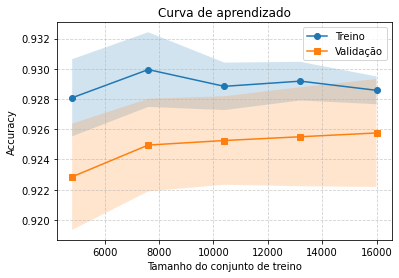

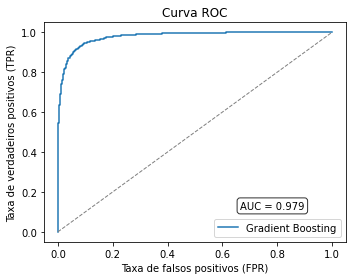

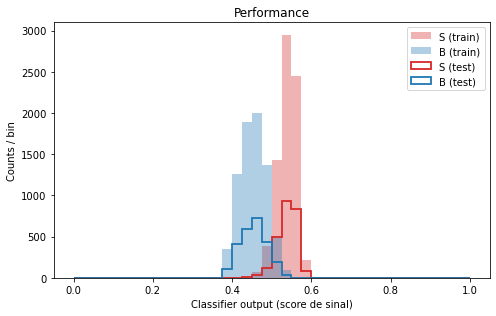

In [20]:
ada = AdaBoostClassifier(n_estimators=400, learning_rate=0.05, random_state=RANDOM_STATE)

ada.fit(X_train, y_train)

# (b) Learning curve (usamos AUC como métrica)
plot_learning_curve(ada, X, y)

# (c) Plot ROC curve
plot_roc_with_auc(ada, X_test, y_test, name="Adaboost Boosting")

# (d) plot treino/validacao
plot_performance(ada, X_train, y_train, X_test, y_test, bins=40, invert=False, title="Performance")

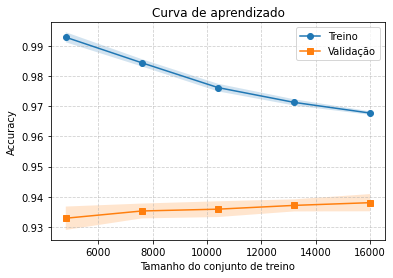

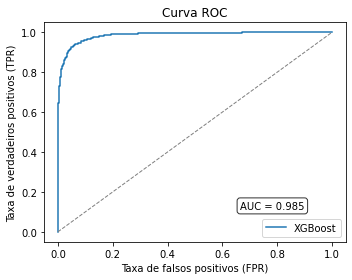

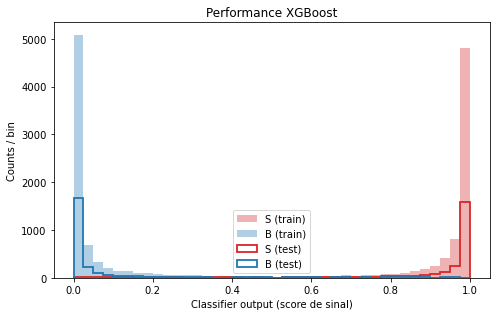

In [21]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    tree_method="hist",  # rápido
    random_state=RANDOM_STATE
)

xgb.fit(X_train, y_train)

# (b) Learning curve (usamos AUC como métrica)
plot_learning_curve(xgb, X, y)

# (c) Plot ROC curve
plot_roc_with_auc(xgb, X_test, y_test, name="XGBoost")

# (d) plot treino/validacao
plot_performance(xgb, X_train, y_train, X_test, y_test, bins=40, invert=False, title="Performance XGBoost")

# 9) Comparando performance

,AUC_train,AUC_test,ACC_train,ACC_test,TPR@predict,TNR@predict
XGBoost,0.996,0.985,0.968,0.939,0.940,0.938
RandomForest,1.000,0.984,1.000,0.934,0.932,0.935
GradBoost tuned,0.990,0.984,0.948,0.933,0.934,0.932
GradBoost,0.988,0.983,0.944,0.934,0.935,0.933
AdaBoost,0.981,0.979,0.929,0.924,0.940,0.908
DT tuned,0.980,0.965,0.931,0.910,0.911,0.909
DT default,0.926,0.920,0.876,0.866,0.868,0.864


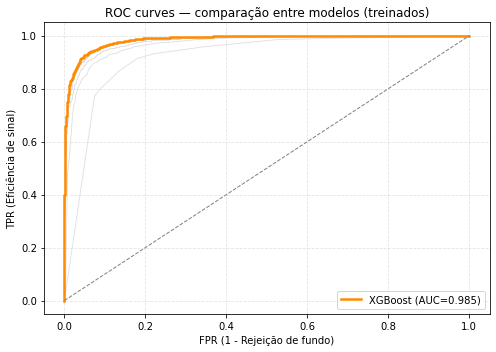

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix

# =========================
# 1) Junte os modelos prontos
# =========================
models = [
    ("DT default", dt),
    ("DT tuned",   grid_dt.best_estimator_),
    ("RandomForest", rf),
    ("GradBoost",    gb),
    ("GradBoost tuned", gb2),
    ("AdaBoost",     ada),
    ("XGBoost", xgb),
]

# =========================
# 2) Métricas + curvas ROC
# =========================
rows = []
roc_curves = []  # (name, fpr, tpr, auc_test)

for name, model in models:
    # scores para ROC/AUC
    if hasattr(model, "predict_proba"):
        y_tr_score = model.predict_proba(X_train)[:, 1]
        y_te_score = model.predict_proba(X_test)[:, 1]
    else:
        y_tr_score = model.decision_function(X_train)
        y_te_score = model.decision_function(X_test)

    # rótulos previstos (para ACC/TPR/TNR)
    y_tr_pred = model.predict(X_train)
    y_te_pred = model.predict(X_test)

    # métricas
    auc_tr = roc_auc_score(y_train, y_tr_score)
    auc_te = roc_auc_score(y_test,  y_te_score)
    acc_tr = accuracy_score(y_train, y_tr_pred)
    acc_te = accuracy_score(y_test,  y_te_pred)

    tn, fp, fn, tp = confusion_matrix(y_test, y_te_pred).ravel()
    tpr = tp / (tp + fn) if (tp + fn) else np.nan   # eficiência de sinal
    tnr = tn / (tn + fp) if (tn + fp) else np.nan   # rejeição de fundo

    rows.append(pd.Series({
        "AUC_train": auc_tr, "AUC_test": auc_te,
        "ACC_train": acc_tr, "ACC_test": acc_te,
        "TPR@predict": tpr, "TNR@predict": tnr
    }, name=name))

    fpr, tpr_curve, _ = roc_curve(y_test, y_te_score)
    roc_curves.append((name, fpr, tpr_curve, auc_te))

# =========================
# 3) Tabela (ordenada por AUC_test)
# =========================
df_cmp = pd.DataFrame(rows).round(3).sort_values("AUC_test", ascending=False)
display(df_cmp)

# =========================
# 4) Plot: todas as ROCs juntas
# =========================
plt.figure(figsize=(7, 5))

# todas as curvas em cinza
for name, fpr, tpr_curve, auc_te in roc_curves:
    plt.plot(fpr, tpr_curve, color="lightgray", lw=0.9, alpha=0.7)

# destaca a melhor
best_name = df_cmp.index[0]
best = next((t for t in roc_curves if t[0] == best_name), None)
if best is not None:
    _, fpr_b, tpr_b, auc_b = best
    plt.plot(fpr_b, tpr_b, color="darkorange", lw=2.5,
             label=f"{best_name} (AUC={auc_b:.3f})")

# diagonal aleatória
plt.plot([0, 1], [0, 1], "--", color="gray", lw=1)

plt.xlabel("FPR (1 - Rejeição de fundo)")
plt.ylabel("TPR (Eficiência de sinal)")
plt.title("ROC curves — comparação entre modelos (treinados)")
plt.legend(loc="lower right")
plt.grid(True, linestyle="--", alpha=0.35)
plt.tight_layout()
plt.show()


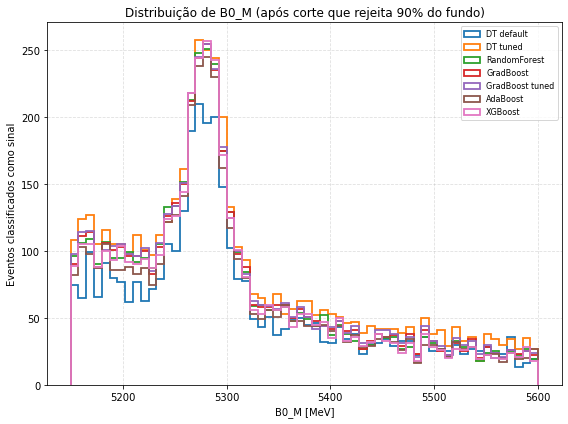

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

df_new = pd.read_csv("/shared_dataset/Met_Stat_HEP_AI_School/Kstarmumu_Data_2016_RM.csv")

X_new = df_new[num_cols].values  # mesmas colunas usadas no treino
B0_M  = df_new["B0_M"].values    # variável a ser plotada

# Encontrar valor com 90% do background (FPR=0.1)
def find_threshold_for_rejection(model, X_test, y_test, fpr_target=0.1):
    if hasattr(model, "predict_proba"):
        scores = model.predict_proba(X_test)[:, 1]
    else:
        scores = model.decision_function(X_test)

    fpr, tpr, thr = roc_curve(y_test, scores)
    idx = np.argmin(np.abs(fpr - fpr_target))
    return thr[idx], scores

models = {
    "DT default": dt,
    "DT tuned": grid_dt.best_estimator_,
    "RandomForest": rf,
    "GradBoost": gb,
    "GradBoost tuned": gb2,
    "AdaBoost": ada,
    "XGBoost": xgb
}

plt.figure(figsize=(8, 6))
for name, model in models.items():
    
    thr, _ = find_threshold_for_rejection(model, X_test, y_test, fpr_target=0.1)

    if hasattr(model, "predict_proba"):
        scores_new = model.predict_proba(X_new)[:, 1]
    else:
        scores_new = model.decision_function(X_new)

    mask_sig = scores_new > thr  

    plt.hist(B0_M[mask_sig], bins=60, histtype="step", lw=1.8, label=name)

plt.xlabel("B0_M [MeV]")
plt.ylabel("Eventos classificados como sinal")
plt.title("Distribuição de B0_M (após corte que rejeita 90% do fundo)")
plt.legend(fontsize=8)
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# Criando uma copia do csv original com o adicional dos scores, neste caso xgb

In [33]:
data_path = "/shared_dataset/Met_Stat_HEP_AI_School/Kstarmumu_Data_2016_RM.csv"
output_path = "./Kstarmumu_Data_2016_RM_xgb.csv"

data = pd.read_csv(data_path)

# Features usadas no treino
features = num_cols

data["xgb_score"] = xgb.predict_proba(data[features])[:, 1]

data.to_csv(output_path, index=False)

# Fazer o mesmo para a amostra de sinal

In [35]:
mc_path = "/shared_dataset/Met_Stat_HEP_AI_School/Kstarmumu_Combined_10K.csv"
output_mc_path = "./Kstarmumu_MC_xgb.csv"

mc = pd.read_csv(mc_path)

features = num_cols

mc["xgb_score"] = xgb.predict_proba(mc[features])[:, 1]

mc.to_csv(output_mc_path, index=False)